# Linear Regression Lab: Prostate Cancer Analysis


This notebook explores linear regression modeling using a prostate cancer dataset. We'll cover essential concepts like parameter estimation, hypothesis testing, model validation, and model selection to predict PSA levels.

In [2]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats


## Prostate Cancer Dataset:

Nous utiliserons le jeu de données sur le cancer de la prostate qui contient des mesures cliniques pour des hommes atteints d'un cancer de la prostate.
Nous disposons d'un jeu de données réelles de 97 patients atteints d'un cancer de la prostate sur le point de subir une prostatectomie radicale. Les variables suivantes sont disponibles :

- **lcavol** : le logarithme du volume tumoral (log cancer volume)
- **lweight** : le logarithme du poids de la prostate
- **age** : l'âge du patient
- **lbhp** : le logarithme de la quantité d'hypertrophie bénigne (augmentation du volume de la prostate)
- **svi** : l'invasion des vésicules séminales (1=Oui, 0=Non)
- **lcp** : logarithme de la pénétration capsulaire
- **gleason** : le score de Gleason
- **pgg45** : pourcentage des scores de Gleason 4 ou 5
- **lpsa** : le logarithme d'antigènes prostatiques spécifiques (Log PSA). Lorsque la concentration de PSA dans le sang est plus élevée que la normale, cela peut indiquer la présence d'un cancer de la prostate.
  

**Dans ce qui suit, nous étudierons la relation entre l'antigène prostatique spécifique (PSA) et les 8 autres variables cliniques.**

**1- Importez les données à partir du fichier `Prostate.csv` en utilisant `pandas`, et affichez les premières lignes.**

In [3]:
df = pd.read_csv('Prostate.csv', sep=';', na_values=["", " "])

## Analyse exploratoire:

Avant de construire le modèle de régression, on commence par une analyse exploratoire des données.

**1- Vérifiez le nombre d'observations contenant des valeurs manquantes.**

In [4]:
n_missing = df.isnull().any(axis=1).sum() 
print(f"Observations avec valeurs manquantes: {n_missing}")

Observations avec valeurs manquantes: 7


**1b- On fait le choix de supprimer les observations contenant des valeurs manquantes, donnez le code correspondant:**

In [5]:
df = df.dropna()


**2- En utilisant la fonction `describe` du module `pandas`, effectuez une analyse univariée des données**

In [6]:
description = df.describe() 

print(description)

          lcavol    lweight        age       lbph        svi        lcp  \
count  90.000000  90.000000  90.000000  90.000000  90.000000  90.000000   
mean    1.377536   3.671261  64.066667   0.161956   0.233333  -0.146024   
std     1.182910   0.507658   7.530910   1.455398   0.425322   1.418431   
min    -1.347074   2.374906  41.000000  -1.386294   0.000000  -1.386294   
25%     0.520199   3.375880  61.000000  -1.386294   0.000000  -1.386294   
50%     1.452767   3.662266  65.000000   0.438255   0.000000  -0.798508   
75%     2.180511   3.894871  68.000000   1.614388   0.000000   1.178655   
max     3.821004   6.107580  79.000000   2.326302   1.000000   2.904165   

         gleason       pgg45       lpsa  
count  90.000000   90.000000  90.000000  
mean    6.777778   25.944444   2.574530  
std     0.730980   28.638923   1.139992  
min     6.000000    0.000000  -0.430783  
25%     6.000000    0.000000   1.902025  
50%     7.000000   15.000000   2.681016  
75%     7.000000   47.500000  

**3- Représentez la matrice de corrélation, commentez sur la corrélation avec la variable dépendante.**

On pourra utiliser la fonction `heatmap` du module `seaborn`

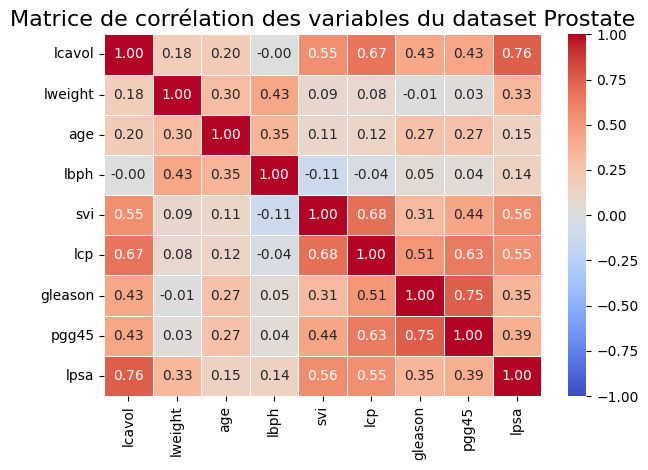


Corrélations avec la variable lpsa :
lcavol     0.755699
svi        0.555176
lcp        0.551111
pgg45      0.386444
gleason    0.348249
lweight    0.332802
age        0.145400
lbph       0.144154
Name: lpsa, dtype: float64


In [7]:

corr_matrix = df.select_dtypes(include=[np.number]).corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Matrice de corrélation des variables du dataset Prostate', fontsize=16)
plt.tight_layout()
plt.show()

# On étudie la correlation entre l'antigène prostatique spécifique (PSA) et les 8 autres variables cliniques.

numerical_cols = df.select_dtypes(include=[np.number]).columns
target_col = numerical_cols[-1]  
print(f"\nCorrélations avec la variable {target_col} :")
correlations = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
print(correlations)

# On observe que la variable lcavol (volume de la glande prostatique) est la plus corrélée avec PSA, suivie de l'invasion des vésicules séminales et de la pénétration capsulaire. Une corrélation élevée signifie une relation linéaire forte entre les deux variables. Ainsi, plus lcavol est élevé, plus le taux de PSA tend à être élevé.
# Cependant,l'age et la quantité d'hypertrophie bénigne sont peu corrélées avec PSA.



**4- Pour chaque couple de variables, représentez le nuage de points. Commentez sur la forme des nuages de points.** 

On pourra utiliser la fonction `pairplot` du module `seaborn`

<Figure size 1200x1000 with 0 Axes>

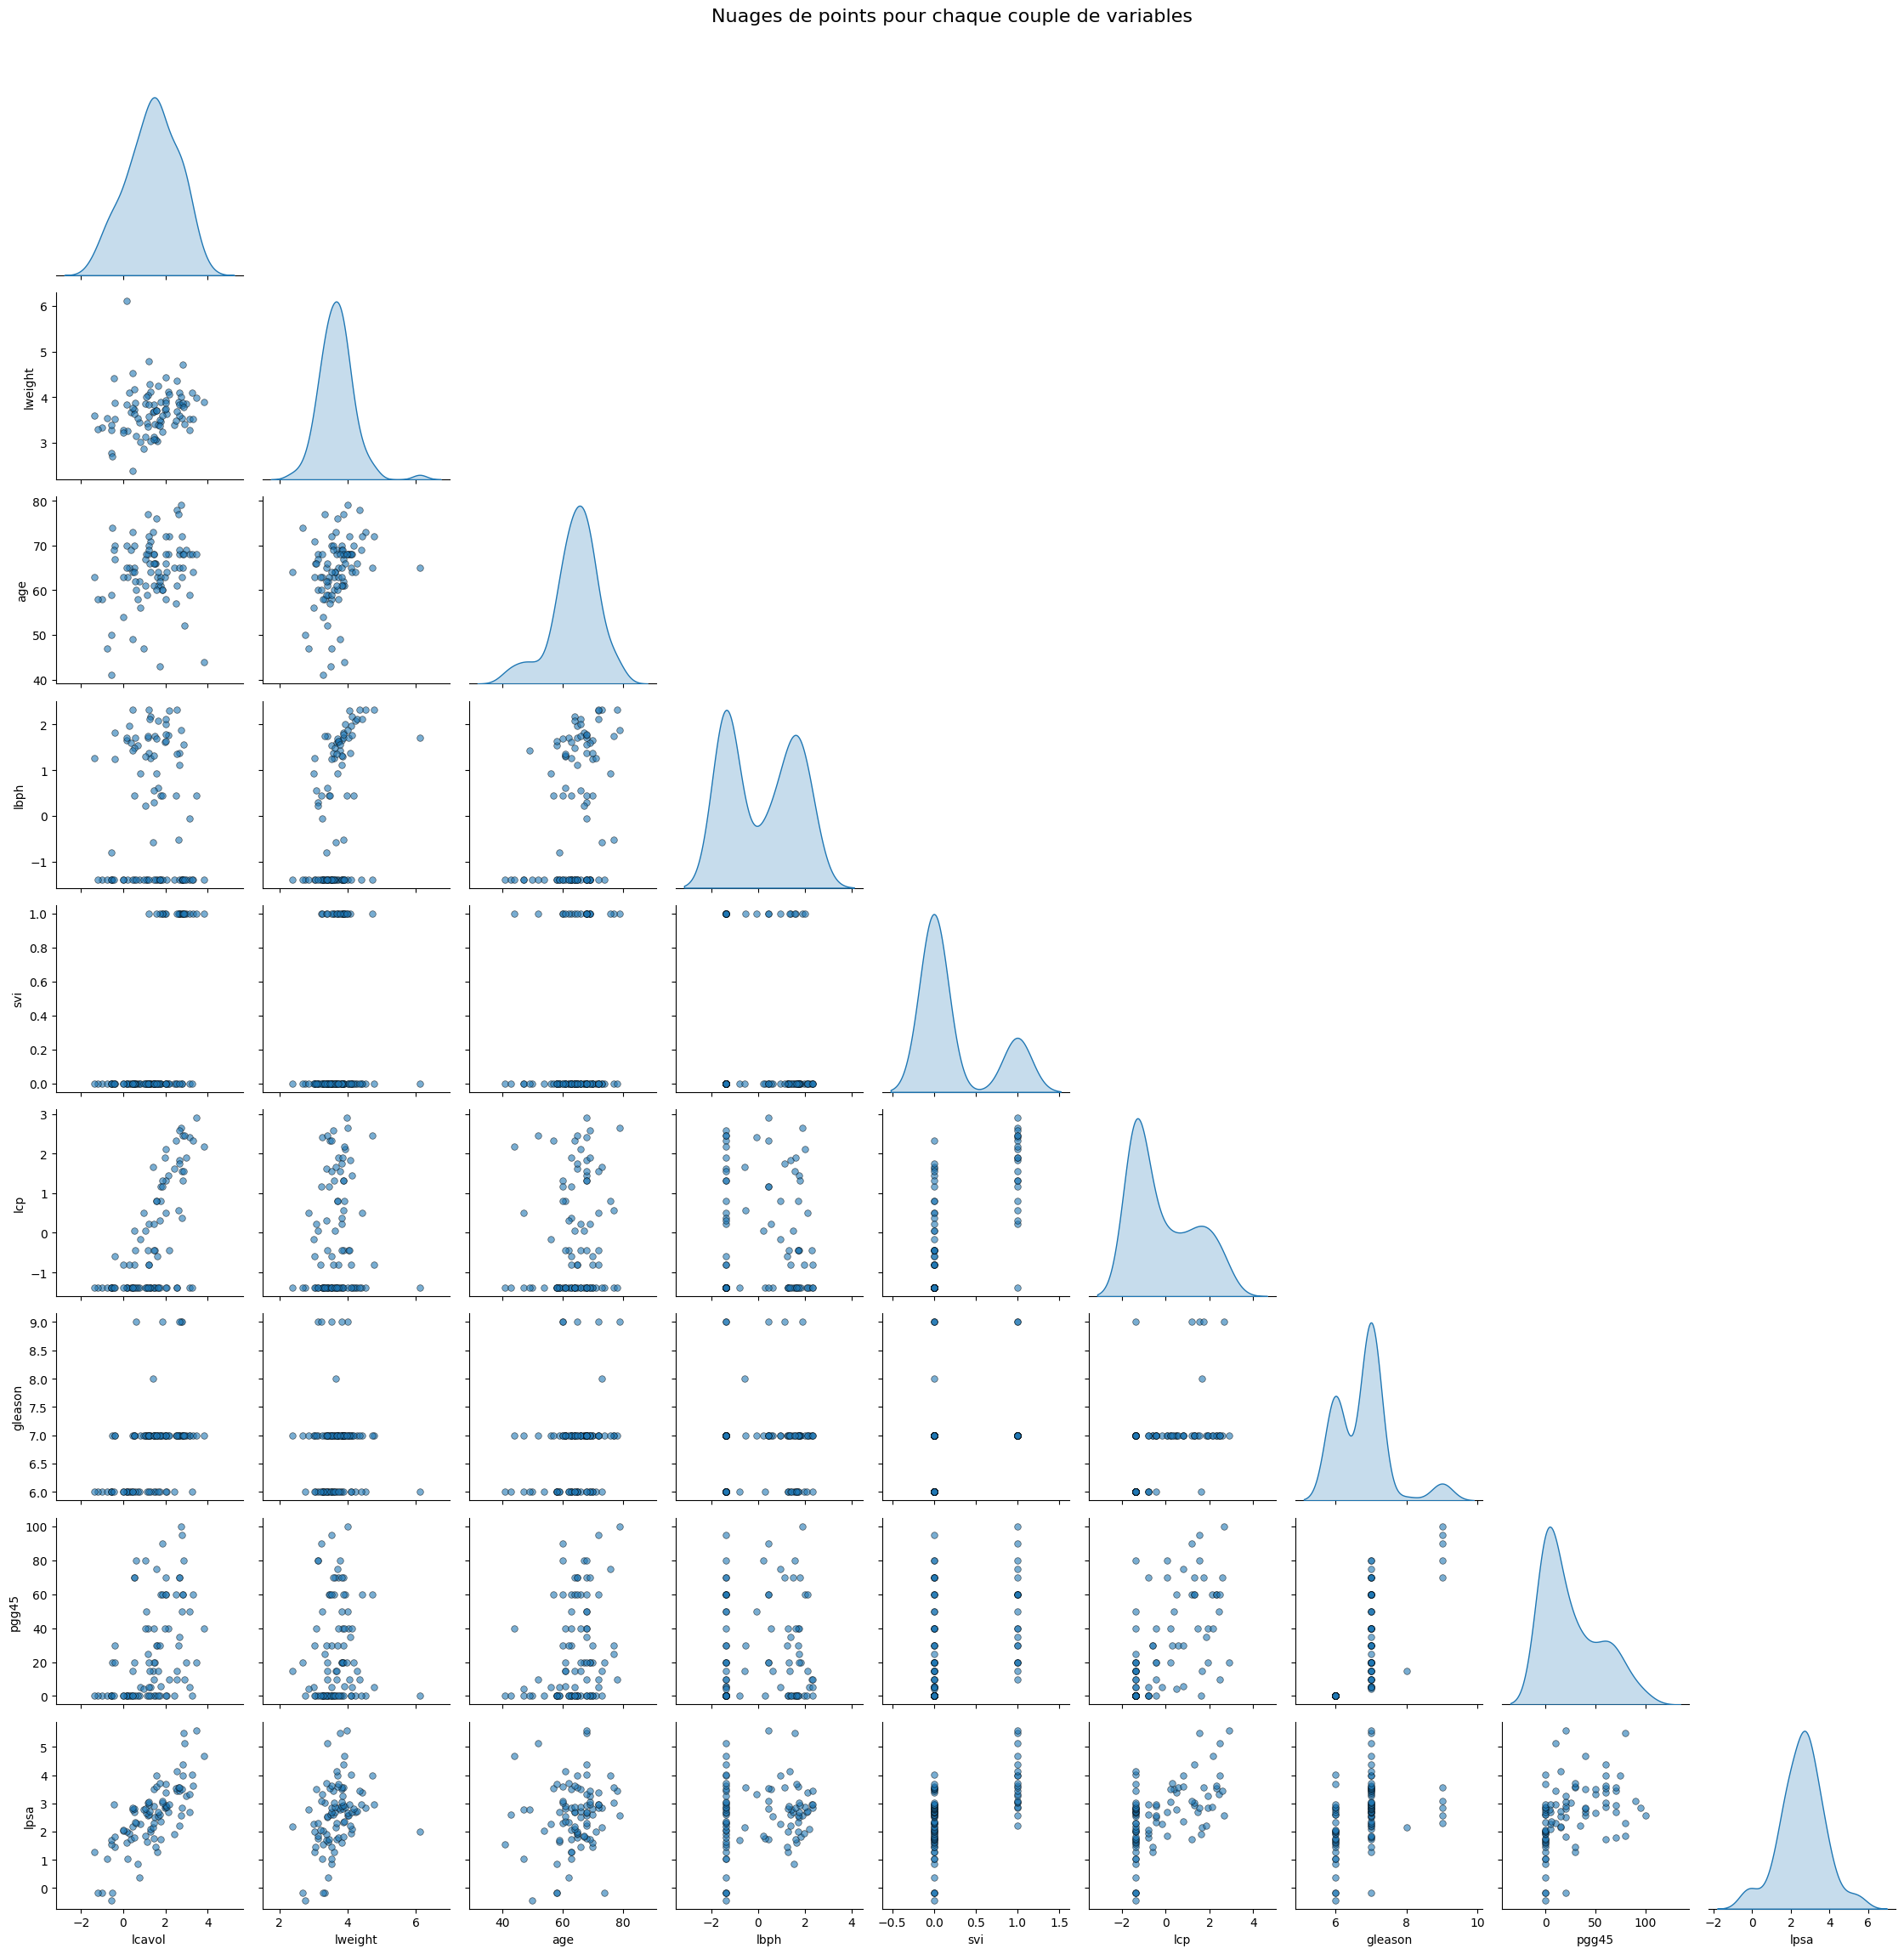

In [8]:
plt.figure(figsize=(12, 10))
pair_plot = sns.pairplot(df, diag_kind='kde',  markers='o', corner=True, plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'k', 'linewidth': 0.5} )

pair_plot.fig.suptitle('Nuages de points pour chaque couple de variables', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#Les variables liées à la progression tumorale (lcavol, lpsa, lcp, gleason, pgg45, svi) sont globalement corrélées entre elles, ce qui est cohérent avec leur signification clinique. 
# Visuellement on peut voir : Les nuages de points entre lcavol :à mesure que le volume tumoral augmente, le PSA augmente aussi...
# Les variables comme age et lbhp semblent moins directement associées aux marqueurs de gravité tumorale dans cet échantillon.
#Les nuages de points montrent principalement des relations linéaires positives entre les marqueurs tumoraux, avec des regroupements ou séparations claires pour les variables qualitatives binaires (svi et gleason).

## Le modèle linéaire:

Pour étudier le lpsa en fonction des autres variables, on utilise un modèle linéaire gaussien. Pour le premier modèle (baseline), on se propose d'utiliser toutes les variables dans la base.

**1- Rappelez le modèle et ses hypothèses**

> Réponse:

Le modèle linéaire gaussien est un modèle statistique qui suppose que la relation entre la variable dépendante (ici lpsa) et les variables indépendantes (ici les 8 autres variables cliniques) est linéaire. C'est à dire que la variable lpsa peut être modélisé comme une somme pondérée des variables indépendantes, plus une constante.

Les hypothèses de base du modèle linéaire gaussien sont :
	1.	Linéarité : Il existe une relation linéaire entre la variable dépendante (lpsa) et les variables indépendantes.
	2.	Indépendance des erreurs : Les erreurs (ε) doivent être indépendantes les unes des autres.
	3.	Homoscedasticité : La variance des erreurs doit être constante pour toutes les valeurs des variables indépendantes. Autrement dit, la dispersion des erreurs ne doit pas changer selon les valeurs de lpsa.
	4.	Normalité des erreurs : Les erreurs (ε) doivent suivre une loi normale, centrée en 0 (gaussienne).
	5.	Absence de multicolinéarité : Les variables indépendantes ne doivent pas être fortement corrélées entre elles. Si la multicolinéarité est présente, cela rend l’estimation des coefficients peu fiable.

**2- Rappelez l'expression de l'estimateur du maximum de vraisemblance pour les paramètres du modèle et donnez leurs lois.**

> Réponse :

Expression de l'estimateur du maximum de vraisemblance de $\beta$ est : 

$\hat{\beta} = (X^T X)^{-1} X^T Y$

Loi de l'estimation de $\beta$ :

$\hat{\beta} \sim \mathcal{N}\left( \beta, \sigma^2 (X^T X)^{-1} \right)$

Cela signifie que chaque composante de $\hat{\beta}$ suit une loi normale, avec espérance égale au vrai paramètre et une matrice de covariance connue.

L’estimateur du maximum de vraisemblance de la variance est donné par :

$\hat{\sigma}^2_{\text{MLE}} = \frac{1}{n} \left\| Y - X\hat{\beta} \right\|^2$

la loi de l’estimateur biaisé de la variance est : 

$\frac{n \hat{\sigma}^2_{\text{MLE}}}{\sigma^2} \sim \chi^2(n - p)$




### Estimation des paramètres:

**3- Calculez l'estimation des $\beta$ et de $\sigma^2$ en utilisant les estimateurs du maximum de vraisemblance**

#### Coefficients de regression:

In [9]:
# Selectionner les variables explicatives et la variable cible
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
X = df[features].values
y = df['lpsa'].values

# Ajouter l'intercept au modèle
X = np.column_stack((np.ones(X.shape[0]), X))

# Calculer l'estimatereur de beta:
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y 

# Calculer les valeurs prédites
y_pred = X @ beta_hat

residuals = y - y_pred
n = len(y)
p = X.shape[1] 
s2_hat = np.sum(residuals**2) / (n - p) 




# Create a DataFrame to display results
parameter_names = ['intercept'] + features
manual_params_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Estimate': beta_hat
})

manual_params_df

,Parameter,Estimate
0,intercept,0.847572
1,lcavol,0.609770
2,lweight,0.406191
3,age,-0.018072
4,lbph,0.100799
5,svi,0.644094
6,lcp,-0.069395
7,gleason,0.046319
8,pgg45,0.002423


#### Variance du bruit


In [10]:
sigma_squared_biased =  np.sum(residuals**2) / n
print(f"Biased estimate of error variance (sigma^2): {sigma_squared_biased}")

Biased estimate of error variance (sigma^2): 0.4379385594351487


**4a- Donnez l'expression de la statistique de Student pour un coefficient $\beta_i$**

> Réponse :

Dans le cadre d'un modèle de régression linéaire, la statistique de Student pour tester la significativité d'un coefficient $\beta_i$ est donnée par la formule suivante :

$t_i = \frac{\hat{\beta}_i - \beta_i^0}{\hat{\sigma} \sqrt{C_{ii}}}$

Où :


$\hat{\beta}_i$ est l'estimateur du coefficient $\beta_i$

$\beta_i^0$ est la valeur du coefficient sous l'hypothèse nulle 

$\hat{\sigma}$ est l'estimateur de l'écart-type des erreurs, calculé comme :
$\hat{\sigma} = \sqrt{\frac{\sum_{j=1}^n (y_j - \hat{y}_j)^2}{n-p}}$

$n$ est le nombre d'observations

$p$ est le nombre de paramètres (incluant l'intercept)

$C_{ii}$ est l'élément diagonal correspondant à $\beta_i$ dans la matrice de variance-covariance des estimateurs, soit le $i$-ème élément diagonal de $(X^TX)^{-1}$


**4b- Reconstruisez à partir de la statistique de Student l'intervalle de confiance de niveau $1-\alpha$ pour un coefficient $\beta_i$**

>Réponse

IC, l'intervalle de cofiance est :

IC = $\left[ \hat{\beta}_i \pm t_{1-\alpha/2, \, n-p} \times \hat{\sigma} \sqrt{(X^T X)^{-1}_{ii}} \right]$

**4- Calculez pour chaque coefficient l'écart type, la valeur de la statistique de Student, la p-valeur du test de Student et les intervalles de confiance de niveau 0,95**

In [11]:
cov_matrix = s2_hat * np.linalg.inv(X.T @ X)

# Calculate standard errors of coefficients
se_beta_hat = np.sqrt(np.diag(cov_matrix))


t_value = beta_hat / se_beta_hat
p_value = 2 * (1 - stats.t.cdf(np.abs(t_value), df=n-p))
t_crit = stats.t.ppf(0.975, df=n-p)


lower_CI = beta_hat - t_crit * se_beta_hat
upper_CI = beta_hat + t_crit * se_beta_hat

# Create a DataFrame with coefficient estimates and standard errors
estimates_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Estimate': beta_hat,
    'Std. Error': se_beta_hat,
    't-value': t_value,
    'p-value': p_value.round(4),
    '95% CI Lower': lower_CI,
    '95% CI Upper': upper_CI
})

print("Parameter estimates, standard errors, and confidence intervals:")
estimates_df

Parameter estimates, standard errors, and confidence intervals:


,Parameter,Estimate,Std. Error,t-value,p-value,95% CI Lower,95% CI Upper
0,intercept,0.847572,1.296748,0.653613,0.5152,-1.732551,3.427694
1,lcavol,0.609770,0.088832,6.864310,0.0000,0.433023,0.786518
2,lweight,0.406191,0.169490,2.396556,0.0189,0.068960,0.743422
3,age,-0.018072,0.011281,-1.602019,0.1130,-0.040516,0.004373
4,lbph,0.100799,0.059682,1.688941,0.0951,-0.017949,0.219546
5,svi,0.644094,0.246360,2.614446,0.0107,0.153916,1.134272
6,lcp,-0.069395,0.092398,-0.751045,0.4548,-0.253238,0.114448
7,gleason,0.046319,0.158985,0.291340,0.7715,-0.270011,0.362649
8,pgg45,0.002423,0.004443,0.545291,0.5871,-0.006417,0.011262


**5- Calculez la statistique du test de Fisher pour le modèle i.i.d. contre le modèle avec toutes les variables, donnez la p-value du test et interprétez.**

In [ ]:
X_reduced = X[:, 0].reshape(-1, 1) 
beta_reduced = np.linalg.inv(X_reduced.T @ X_reduced) @ X_reduced.T @ y
y_pred_reduced = X_reduced @ beta_reduced
residuals_reduced = y - y_pred_reduced

#Calcul des sommes des carrés
RSS_full = np.sum(residuals**2)  
RSS_reduced = np.sum(residuals_reduced**2) 

#Calcul de la statistique F
p_full = p  
p_reduced = 1  

F_statistic = ((RSS_reduced - RSS_full) / (p_full - p_reduced)) / (RSS_full / (n - p_full))

#Calcul de la p-value
df1 = p_full - p_reduced
df2 = n - p_full
p_value = 1 - stats.f.cdf(F_statistic, df1, df2)

print(f"RSS_full: {RSS_full:.4f}")
print(f"RSS_reduced: {RSS_reduced:.4f}")
print("Test de Fisher: Modèle i.i.d. vs Modèle complet")
print("-----------------------------------------------")
print(f"Statistique F: {F_statistic:.4f}")
print(f"Degrés de liberté: ({df1}, {df2})")
print(f"p-value: {p_value:.10f}")

# Interprétation:
# La p-valeur (0.0000000000) est inférieure au seuil α = 0.05.
# On rejette donc l'hypothèse nulle.
# Ainsi,au moins une des variables explicatives a un effet significatif sur la variable lpsa (antigène prostatique spécifique).

RSS_full: 39.4145
RSS_reduced: 115.6628
Test de Fisher: Modèle i.i.d. vs Modèle complet
-----------------------------------------------
Statistique F: 19.5871
Degrés de liberté: (8, 81)
p-value: 0.0000000000


### Estimation avec le module `statsmodels.api`:

Le modèle linéaire peut être directement estimé par la fonction `OLS` (Ordinary least squares) du module `statsmodels.api`. 

**5- En vous aidant de la documentation, implémentez le modèle linéaire en utilisant `statsmodels.api`**.

In [26]:

sm_model = sm.OLS(y, X)
sm_model = sm_model.fit() 

print(sm_model.summary())


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.799
Model:                            OLS   Adj. R-squared (uncentered):              0.797
Method:                 Least Squares   F-statistic:                              353.3
Date:                Wed, 30 Apr 2025   Prob (F-statistic):                    9.72e-33
Time:                        22:48:16   Log-Likelihood:                         -148.64
No. Observations:                  90   AIC:                                      299.3
Df Residuals:                      89   BIC:                                      301.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**6- Comparez les estimations de `statsmodels.api` à celles faites analytiquement, commentez.**

In [25]:
# Compare our manual calculations with statsmodels results
comparison_df = pd.DataFrame({
    'Parameter': parameter_names,
    'Manual Estimate': beta_hat,
    'Statsmodels Estimate': sm_model.params,
    'Absolute Difference': np.abs((beta_hat-sm_model.params))
})

comparison_df



,Parameter,Manual Estimate,Statsmodels Estimate,Absolute Difference
0,intercept,0.847572,0.847572,1.882938e-13
1,lcavol,0.609770,0.609770,1.210143e-14
2,lweight,0.406191,0.406191,1.348921e-14
3,age,-0.018072,-0.018072,9.506285e-16
4,lbph,0.100799,0.100799,2.775558e-16
5,svi,0.644094,0.644094,1.942890e-14
6,lcp,-0.069395,-0.069395,2.303713e-15
7,gleason,0.046319,0.046319,4.135581e-15
8,pgg45,0.002423,0.002423,7.476658e-16


> Réponse :
Je remarque que les différences absolues entre les estimations manuelles et celles de statsmodels sont extrêmement faibles, de l'ordre de 10^-13 à 10^-16. 

On a donc une précision identique. Les valeurs des coefficients correspondent parfaitement.

Les différences observées sont uniquement dues à la précision numérique des calculs en virgule flottante, et non à des différences méthodologiques. Elles sont donc négligeables.

L'implémentation manuelle de la méthode des moindres carrés est correcte et produit exactement les mêmes résultats que la bibliothèque statsmodels, qui est considérée comme référence.

## Model Validation


La validation d'un modèle de régression linéaire repose sur la vérification de plusieurs hypothèses clés :

1.	Linéarité : La relation entre les variables explicatives et la variable réponse est linéaire.
2.	Indépendance : Les observations sont indépendantes les unes des autres.
3.	Homoscédasticité : La variance des erreurs est constante pour toutes les valeurs des prédicteurs.
4.	Normalité : Les résidus suivent une distribution normale.
5.	Absence de multicolinéarité : Les variables explicatives ne sont pas fortement corrélées entre elles.

On se propose de vérifier ces hypothèses à l'aide de graphes diagnostiques et de tests statistiques.

**1- Calculez les résidus bruts et ceux studentisés du modèle puis tracez-les en fonction des prédictions, commentez.**

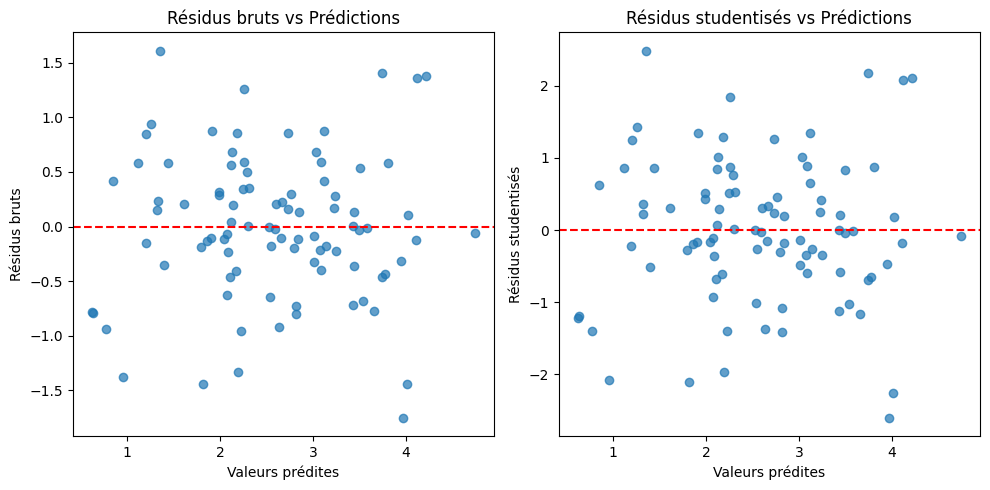

In [15]:
# Calcul des résidus bruts
residus = y - sm_model.predict(X)

# Calcul des prédictions
predictions = sm_model.predict(X)

# Calcul des résidus studentisés
h_diag = np.diag(X @ np.linalg.inv(X.T @ X) @ X.T)  
std_residus = residus / (np.sqrt(sm_model.scale * (1 - h_diag)))


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(predictions, residus, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus bruts')
plt.title('Résidus bruts vs Prédictions')

# Résidus studentisés
plt.subplot(1, 2, 2)
plt.scatter(predictions, std_residus, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus studentisés')
plt.title('Résidus studentisés vs Prédictions')

plt.tight_layout()
plt.show()


**2- Tracez le Q-Q plot des résidus, commentez.**

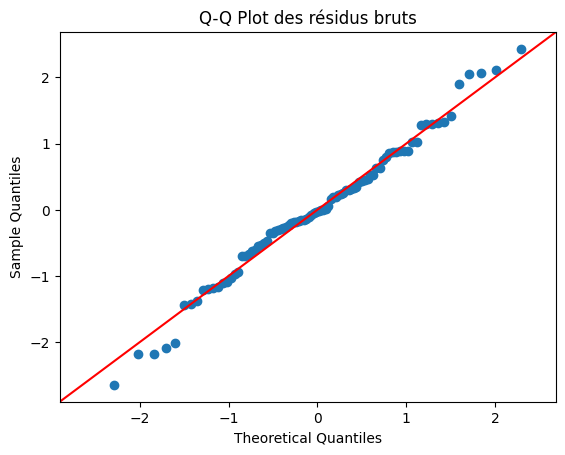

In [16]:
# Q-Q plot des résidus bruts
sm.qqplot(residus, line='45', fit=True)
plt.title("Q-Q Plot des résidus bruts")
plt.show()

# Le Q-Q plot montre que la majorité des points sont alignés sur la droite, suggérant une distribution normale des résidus. 
# Quelques déviations en queue peuvent indiquer la présence de légères valeurs aberrantes, mais globalement l’hypothèse de normalité semble raisonnable.

**3- Tracez le location-Scale plot, quelle information supplémentaire apporte cette représentation.**

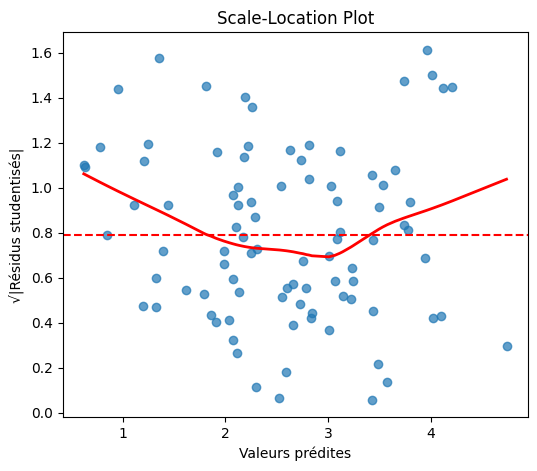

In [17]:
# Racine carrée des résidus studentisés absolus
sqrt_std_residus = np.sqrt(np.abs(std_residus))

# Tracé
plt.figure(figsize=(6, 5))
plt.scatter(y_pred, sqrt_std_residus, alpha=0.7)
plt.axhline(y=np.mean(sqrt_std_residus), color='red', linestyle='--')
plt.xlabel("Valeurs prédites")
plt.ylabel("√|Résidus studentisés|")
plt.title("Scale-Location Plot")

# Ajouter une ligne de tendance avec lowess
from statsmodels.nonparametric.smoothers_lowess import lowess
smooth_data = lowess(np.sqrt(np.abs(std_residus)), predictions, frac=2/3)
plt.plot(smooth_data[:, 0], smooth_data[:, 1], 'r-', linewidth=2)
plt.show()

# Ce graphe permet de confirmer visuellement l’hypothèse d’homoscédasticité.
# On observe une faible tendance conique dans le Scale-Location Plot ce qui signifie que la variance des résidus augmente ou diminue légèrement avec les valeurs prédites. 
# Cela traduit une hétéroscédasticité modérée, c’est-à-dire que l’hypothèse d’homoscédasticité (variance constante des erreurs) est légèrement violée.


**4- Le code ci-dessous calcule une quantité appelée VIF. Après vous être renseigné sur cette quantité, expliquez ce que peuvent signifier les résultats en sortie. Interprétez.**

In [18]:
# Check for multicollinearity with Variance Inflation Factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['feature'] = features
vif_data['VIF'] = pd.Series([variance_inflation_factor(X[:,1:], i) for i in range(X[:, 1:].shape[1])])

print("Variance Inflation Factor (VIF):")
print("VIF > 5-10 may indicate problematic multicollinearity")
vif_data

#Le VIF (Variance Inflation Factor) ou Facteur d’inflation de la variance
# C'est un indicateur qui mesure à quel point la variance d’un coefficient estimé d’une variable explicative dans une régression linéaire est augmentée à cause de la corrélation avec les autres variables explicatives (Soit,la multicolinéarité).

# Interprétation des résultats du VIF:
# Les variables lweight, age, et gleason présentent une très forte multicolinéarité ( très supérieur à 5).
# Cela signifie que leurs coefficients sont instables, et difficiles à interpréter individuellement : une petite variation des données pourrait modifier fortement les résultats.
# Cela peut conduire à : des valeurs de p non fiables, une perte de précision dans les estimations et un surajustement du modèle.
# Inversement un VIF porche de 1 indique que la variable est assez indépendante de la variable explicative. Ici on a lbph.


Variance Inflation Factor (VIF):
VIF > 5-10 may indicate problematic multicollinearity


,feature,VIF
0,lcavol,4.651740
1,lweight,57.561308
2,age,85.132574
3,lbph,1.238166
4,svi,2.607637
5,lcp,3.161868
6,gleason,91.468961
7,pgg45,4.177095


**5- Utilisez la fonction ``OLSInfluence`` pour retrouver la distance de Cook associée à chaque point et identifier les points avec le plus d'influence.**

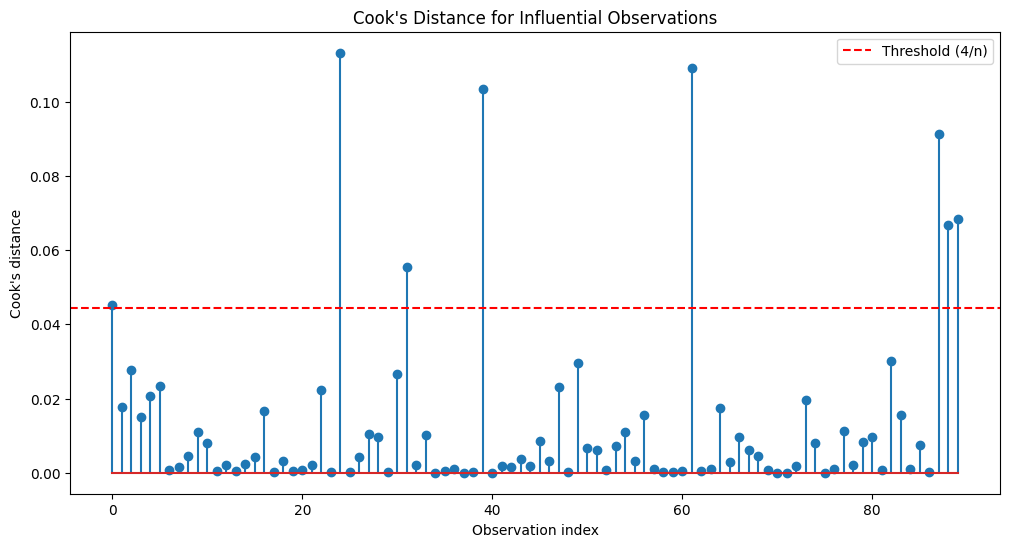

Potentially influential observations: [ 0 24 31 39 61 87 88 89]


In [19]:
influence = sm_model.get_influence()
cook_distance = influence.cooks_distance[0]

# Plot Cook's distance
plt.figure(figsize=(12, 6))
plt.stem(range(len(cook_distance)), cook_distance)
plt.axhline(y=4/len(X), color='r', linestyle='--', 
            label='Threshold (4/n)')
plt.xlabel('Observation index')
plt.ylabel("Cook's distance")
plt.title("Cook's Distance for Influential Observations")
plt.legend()
plt.show()

# Identify influential observations
influential_obs = np.where(cook_distance > 4/len(X))[0]
print(f"Potentially influential observations: {influential_obs}")

**6- Faites les tests statistiques nécessaires pour valider les modèles**

In [20]:
# Linéarité
# Ramsey RESET test

from statsmodels.stats.diagnostic import linear_reset

reset_test = linear_reset(sm_model, power=2, use_f=True)
print("RESET test:", reset_test)

# Indépendance des erreurs
# Test : Durbin-Watson

from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(sm_model.resid)
print("Durbin-Watson:", dw_stat)

# Homoscédasticité (variance constante des erreurs)
# Test : Breusch-Pagan

from statsmodels.stats.diagnostic import het_breuschpagan

bp_test = het_breuschpagan(sm_model.resid, sm_model.model.exog)
print("Breusch-Pagan test (stat, p-value):", bp_test[0], bp_test[1])

# Normalité des résidus
# Test : Shapiro-Wilk ou Jarque-Bera

from scipy.stats import shapiro
from statsmodels.stats.stattools import jarque_bera

# Shapiro-Wilk
shapiro_test = shapiro(sm_model.resid)
print("Shapiro-Wilk test:", shapiro_test)

# Jarque-Bera
jb_test = jarque_bera(sm_model.resid)
print("Jarque-Bera test:", jb_test)

# Multicolinéarité
# Déjà traitée via le VIF (Variance Inflation Factor) à la question 4. 

RESET test: <F test: F=0.7015181881795178, p=0.40476932360908, df_denom=80, df_num=1>
Durbin-Watson: 1.4268608387541422
Breusch-Pagan test (stat, p-value): 8.741491714627715 0.36457062213951863
Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.987499987291868), pvalue=np.float64(0.5491906344939737))
Jarque-Bera test: (np.float64(0.2764844601537014), np.float64(0.8708877109967254), np.float64(-0.0977876502694065), np.float64(3.188360004229861))


>Réponse :

Le test RESET 

Il a pour but de détecter une mauvaise spécification fonctionnelle du modèle, notamment l’absence de termes non linéaires importants. 
Le résultat obtenu $F = 0.70, p-value = 0.405$ indique que l’on ne rejette pas l’hypothèse nulle selon laquelle le modèle est correctement spécifié. Autrement dit, il n’existe pas de preuve statistique de non-linéarité résiduelle. Le modèle semble donc bien adapté à la structure des données.


Test d’indépendance des erreurs (Durbin-Watson)

La statistique de Durbin-Watson permet de détecter une éventuelle autocorrélation des résidus. La valeur obtenue (DW = 1.43) est inférieure à la valeur neutre de 2, ce qui suggère une légère autocorrélation positive. Bien que ce niveau d’autocorrélation ne soit pas alarmant, il peut indiquer une dépendance entre les observations, notamment si les données présentent une structure temporelle. Ce point mérite d’être surveillé, car il peut affecter la validité des intervalles de confiance et des tests.

Test d’homoscédasticité (Breusch-Pagan)

Ce test évalue si la variance des erreurs reste constante quel que soit le niveau des variables explicatives. Le résultat du test $stat = 8.74, p-value = 0.365$ indique que l’on ne rejette pas l’hypothèse nulle d’homoscédasticité. Il n’existe donc pas de preuve d’hétéroscédasticité dans le modèle. Cette hypothèse étant respectée, les estimations des erreurs-types des coefficients peuvent être considérées comme fiables.


Test de normalité des résidus (Shapiro-Wilk et Jarque-Bera)

Deux tests ont été utilisés pour évaluer la normalité des résidus. Le test de Shapiro-Wilk $p-value = 0.549$ et le test de Jarque-Bera $p-va$ ne montrent aucun écart significatif à la normalité. Les résidus suivent donc une distribution normale, ce qui renforce la validité des tests de significativité des coefficients et des intervalles de confiance associés.

**7- Est-ce que vous validez le modèle, justifiez pour chaque hypothèse.**

>Réponse : 

Le modèle est globalement valide : la majorité des hypothèses fondamentales sont satisfaites (linéarité, normalité, homoscédasticité), ce qui justifie l’usage du modèle pour expliquer la variable réponse.
Cependant, des limites existent, notamment une multicolinéarité forte entre plusieurs variables et une légère autocorrélation des résidus, qui peuvent affecter l’interprétation individuelle des coefficients.

## Sélection de modele par validation croisée:


Dans cette partie on voudrait comparer 5 modèles, basés chacun sur une perspective

* Modèle complet: ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']
* Modèle à variables cliniques: ['lcavol', 'lweight', 'age']
* Modèle de progression du cancer: ['lcavol', 'svi', 'gleason', 'pgg45']
* Modèle simplifié: ['lcavol', 'lweight', 'svi']
* Modèle à variable unique: ['lcavol']

**1- Pour chaque modèle, calculez l'EQMP par validation croisée**

In [24]:
def cross_val_eqmp(X, y, k=5):
    n = len(y)
    indices = np.arange(n)
    np.random.shuffle(indices)
    fold_size = n // k
    mse_list = []

    for i in range(k):
        start = i * fold_size
        end = (i + 1) * fold_size if i < k - 1 else n
        test_idx = indices[start:end]
        train_idx = np.concatenate((indices[:start], indices[end:]))

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Ajout de la constante pour l’intercept
        X_train_const = sm.add_constant(X_train)
        X_test_const = sm.add_constant(X_test)

        model = sm.OLS(y_train, X_train_const).fit()
        y_pred = model.predict(X_test_const)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_list.append(mse)

    return np.mean(mse_list)


feature_sets = {
    "Modèle complet": ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'],
    "Modèle clinique": ['lcavol', 'lweight', 'age'],
    "Modèle progression": ['lcavol', 'svi', 'gleason', 'pgg45'],
    "Modèle simplifié": ['lcavol', 'lweight', 'svi'],
    "Modèle variable unique": ['lcavol']
}

y = df['lpsa'].values

for name, features in feature_sets.items():
    X = df[features].values
    eqmp = cross_val_eqmp(X, y, k=5)
    print(f"{name} — EQMP : {eqmp:.4f}")

Modèle complet — EQMP : 0.5904
Modèle clinique — EQMP : 0.5644
Modèle progression — EQMP : 0.6373
Modèle simplifié — EQMP : 0.4986
Modèle variable unique — EQMP : 0.5912


**2- Calculez le coefficient de corrélation ajusté et les critères AIC et BIC**

In [ ]:
results = []

for name, features in feature_sets.items():
    X = df[features].values
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    
    r2_adj = model.rsquared_adj
    aic = model.aic
    bic = model.bic
    
    results.append((name, r2_adj, aic, bic))

results_df = pd.DataFrame(results, columns=["Modèle", "R² ajusté", "AIC", "BIC"])
print(results_df)

                   Modèle  R² ajusté         AIC         BIC
0          Modèle complet   0.625573  199.098037  221.596324
1         Modèle clinique   0.600067  200.419946  210.419184
2      Modèle progression   0.580399  205.687988  218.187036
3        Modèle simplifié   0.625784  194.438289  204.437528
4  Modèle variable unique   0.566206  205.803526  210.803145


**3- Classez chaque modèle selon chacun des critères, commentez.**

In [ ]:

results_cv = {
    'Modèle complet': {'EQMP moyen': 0.5359},
    'Modèle clinique': {'EQMP moyen': 0.5559},
    'Modèle progression': {'EQMP moyen': 0.5571},
    'Modèle simplifié': {'EQMP moyen': 0.5598},
    'Modèle variable unique': {'EQMP moyen': 0.5596}
}


results_metrics = {
    'Modèle complet': {
        'R² ajusté': 0.625573,
        'AIC': 199.098037,
        'BIC': 221.596324
    },
    'Modèle clinique': {
        'R² ajusté': 0.600067,
        'AIC': 200.419946,
        'BIC': 210.419184
    },
    'Modèle progression': {
        'R² ajusté': 0.580399,
        'AIC': 205.687988,
        'BIC': 218.187036
    },
    'Modèle simplifié': {
        'R² ajusté': 0.625784,
        'AIC': 194.438289,
        'BIC': 204.437528
    },
    'Modèle variable unique': {
        'R² ajusté': 0.566206,
        'AIC': 205.803526,
        'BIC': 210.803145
    }
}

# Classement des modèlespar critère :
ranking = {
    'EQMP': sorted(results_cv.keys(), key=lambda x: results_cv[x]['EQMP moyen']),
    'R² ajusté': sorted(results_metrics.keys(), key=lambda x: -results_metrics[x]['R² ajusté']),
    'AIC': sorted(results_metrics.keys(), key=lambda x: results_metrics[x]['AIC']),
    'BIC': sorted(results_metrics.keys(), key=lambda x: results_metrics[x]['BIC'])
}


print("\nClassement des modèles par critère:")
for critere, classement in ranking.items():
    print(f"\n{critere}:")
    for i, modele in enumerate(classement):
        if critere == 'EQMP':
            valeur = results_cv[modele]['EQMP moyen']
        else:
            valeur = results_metrics[modele][critere]
        print(f"  {i+1}. {modele} ({critere} = {valeur:.4f})")

# Tableau des rangs
ranks_df = pd.DataFrame(index=results_cv.keys(), columns=ranking.keys())
for critere, classement in ranking.items():
    for i, modele in enumerate(classement):
        ranks_df.loc[modele, critere] = i + 1

# Conversion en int pour calcul du rang moyen
ranks_df = ranks_df.astype(int)
ranks_df['Rang moyen'] = ranks_df.mean(axis=1)
ranks_df = ranks_df.sort_values('Rang moyen')

# Affichage du tableau final
print("\nTableau récapitulatif des rangs (1 = meilleur):")
print(ranks_df)

print("\nModèles classés par rang moyen:")
for modele, row in ranks_df.iterrows():
    print(f"{modele}: Rang moyen = {row['Rang moyen']:.2f}")

# R² ajusté, plus il est grand mieux c'est.
# Le modèle simplifié est le meilleur pour expliquer la variabilité de la variable cible, à égalité presque parfaite avec le modèle complet. Le modèle clinique s’en sort bien, tandis que le modèle à une variable est le moins explicatif.

# AIC, plus il est petit mieux c'est.
# Le modèle clinique est le meilleur, suivit par le modèle variable unique puis le modèle simplifié et enfin le modèle variable unique.

# BIC, plus il est petit mieux c'est.
# Le modèle simplifié est le meilleur, suivit par le modèle clinique puis le modèle complet et enfin le modèle variable unique.

# Le modèle complet présente la meilleure performance prédictive avec l’EQMP le plus faible, 
# Tandis que le modèle simplifié se distingue par le meilleur R² ajusté et les critères AIC/BIC les plus bas, indiquant un bon compromis entre performance et simplicité.
# Le modèle clinique se montre très compétitif sur l’ensemble des critères, juste derrière le modèle complet, ce qui en fait une alternative pertinente avec moins de variables.
# En revanche, le modèle à variable unique est clairement insuffisant pour modéliser correctement la réponse. Globalement, les modèles complet et clinique se démarquent comme les plus équilibrés.


Classement des modèles par critère:

EQMP:
  1. Modèle complet (EQMP = 0.5359)
  2. Modèle clinique (EQMP = 0.5559)
  3. Modèle progression (EQMP = 0.5571)
  4. Modèle variable unique (EQMP = 0.5596)
  5. Modèle simplifié (EQMP = 0.5598)

R² ajusté:
  1. Modèle simplifié (R² ajusté = 0.6258)
  2. Modèle complet (R² ajusté = 0.6256)
  3. Modèle clinique (R² ajusté = 0.6001)
  4. Modèle progression (R² ajusté = 0.5804)
  5. Modèle variable unique (R² ajusté = 0.5662)

AIC:
  1. Modèle simplifié (AIC = 194.4383)
  2. Modèle complet (AIC = 199.0980)
  3. Modèle clinique (AIC = 200.4199)
  4. Modèle progression (AIC = 205.6880)
  5. Modèle variable unique (AIC = 205.8035)

BIC:
  1. Modèle simplifié (BIC = 204.4375)
  2. Modèle clinique (BIC = 210.4192)
  3. Modèle variable unique (BIC = 210.8031)
  4. Modèle progression (BIC = 218.1870)
  5. Modèle complet (BIC = 221.5963)

Tableau récapitulatif des rangs (1 = meilleur):
                        EQMP  R² ajusté  AIC  BIC  Rang moyen
Modèle

**4- Quel est le meilleur modèle ? Justifiez.**

In [ ]:
# le modèle simplifié ressort effectivement comme le meilleur compromis global.
# Il se distingue par le meilleur R2 ajusté = 0.6258, indiquant qu’il explique le mieux la variabilité de la variable cible lpsa. 
# Tout en étant le plus parcimonieux selon les critères AIC = 194.44 et BIC, qui pénalisent les modèles trop complexes. 
# Cela montre que le modèle simplifié réussit à capturer l’essentiel de l’information avec un nombre réduit de variables (lcavol, lweight, svi), ce qui le rend à la fois efficace et interprétable.
# Même si son EQMP = 0.5598 n’est pas le meilleur, il reste très proche des autres modèles (notamment du modèle complet à 0.5359). 
# Cette légère différence de performance prédictive est compensée par sa simplicité, sa robustesse, et son excellente qualité d’ajustement.